In [1]:
## imports
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import scipy.stats as stats

In [2]:
## Load data
filepath = "../eewimmer/flavors_of_cacao.csv"
chocolate = pd.read_csv(filepath)
chocolate.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [3]:
chocolate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company 
(Maker-if known)         1795 non-null   object 
 1   Specific Bean Origin
or Bar Name  1795 non-null   object 
 2   REF                               1795 non-null   int64  
 3   Review
Date                       1795 non-null   int64  
 4   Cocoa
Percent                     1795 non-null   object 
 5   Company
Location                  1795 non-null   object 
 6   Rating                            1795 non-null   float64
 7   Bean
Type                         1794 non-null   object 
 8   Broad Bean
Origin                 1794 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


In [4]:
#Rename column headers
chocolate.columns = [
    'company_maker',
    'specific_bean_origin_or_bar_name',
    'ref',
    'review_date',
    'cocoa_percent',
    'company_location',
    'rating',
    'bean_type',
    'broad_bean_origin'
]
print(chocolate.columns)

Index(['company_maker', 'specific_bean_origin_or_bar_name', 'ref',
       'review_date', 'cocoa_percent', 'company_location', 'rating',
       'bean_type', 'broad_bean_origin'],
      dtype='object')


In [5]:
####DATA CLEANING
chocolate['cocoa_percent'].str.replace('%', '').astype(float)
chocolate['cocoa_percent'] = chocolate['cocoa_percent'].str.replace('%', '').astype(float)



In [32]:
chocolate = chocolate.drop(columns=["specific_bean_origin_or_bar_name"])
chocolate.head()


,company_maker,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_bean_origin
429,Chokolat Elot (Girard),1149,2013,42.0,Martinique,2.75,,Martinique
984,Luker,552,2010,46.0,Colombia,2.75,,"Colombia, Ecuador"
90,AMMA,572,2010,50.0,Brazil,3.75,Forastero (Parazinho),Brazil
1423,Santander (Compania Nacional),32,2006,53.0,Colombia,2.00,Forastero (Nacional),Colombia
342,Caoni (Tulicorp),266,2008,55.0,Ecuador,3.00,Forastero (Arriba),Ecuador


In [33]:
chocolate = chocolate.dropna()
chocolate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1793 entries, 429 to 834
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company_maker      1793 non-null   object 
 1   ref                1793 non-null   int64  
 2   review_date        1793 non-null   int64  
 3   cocoa_percent      1793 non-null   float64
 4   company_location   1793 non-null   object 
 5   rating             1793 non-null   float64
 6   bean_type          1793 non-null   object 
 7   broad_bean_origin  1793 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 126.1+ KB


In [8]:
print(chocolate.broad_bean_origin)

0       Sao Tome
1           Togo
2           Togo
3           Togo
4           Peru
          ...   
1790        Peru
1791       Congo
1792       India
1793       India
1794      Brazil
Name: broad_bean_origin, Length: 1793, dtype: object


In [9]:
#data to view the number of manufacturing companies per country
chocolate['company_location'].value_counts()

company_location
U.S.A.               763
France               156
Canada               124
U.K.                  96
Italy                 63
Ecuador               54
Australia             49
Belgium               40
Switzerland           38
Germany               35
Austria               26
Spain                 25
Colombia              23
Hungary               22
Venezuela             20
Japan                 17
Brazil                17
Peru                  17
Madagascar            17
New Zealand           17
Denmark               15
Vietnam               11
Scotland              10
Guatemala             10
Israel                 9
Costa Rica             9
Argentina              9
Poland                 8
Lithuania              6
Honduras               6
South Korea            5
Nicaragua              5
Sweden                 5
Domincan Republic      5
Ireland                4
Netherlands            4
Fiji                   4
Sao Tome               4
Puerto Rico            4
Mexico  

In [10]:
#thats too many countries. look at the top 10 and create new df
top_countries = chocolate['company_location'].value_counts().head(10).reset_index()
top_countries.columns = ['company_location', 'count']
top_countries.head()

,company_location,count
0,U.S.A.,763
1,France,156
2,Canada,124
3,U.K.,96
4,Italy,63


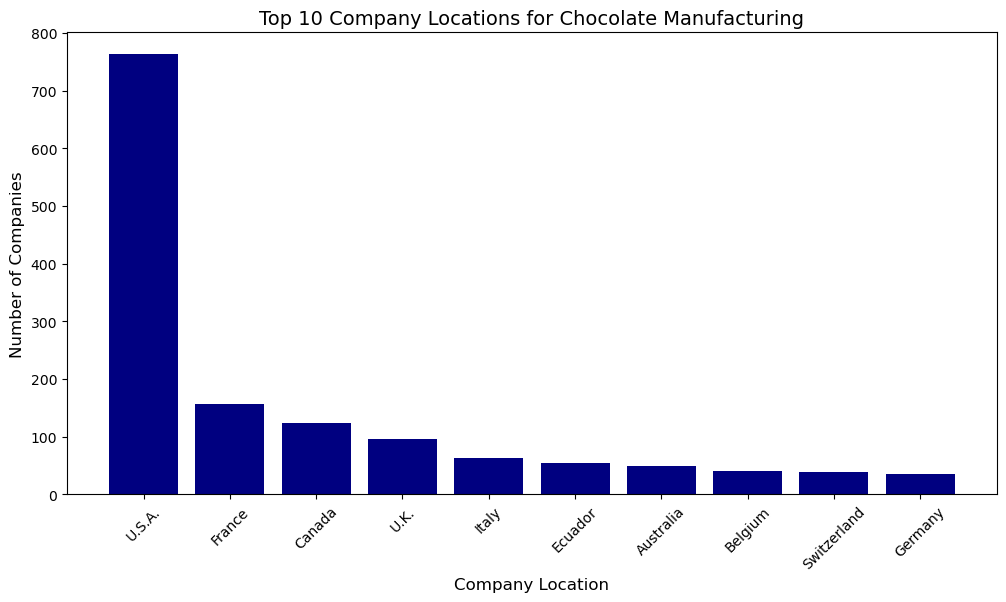

In [11]:
#bar chart
plt.figure(figsize=(12, 6))

plt.bar(top_countries['company_location'], top_countries['count'], color='navy')
plt.title('Top 10 Company Locations for Chocolate Manufacturing', fontsize=14)
plt.xlabel('Company Location', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [12]:
#number of rewviews per year
reviews = chocolate['review_date'].value_counts()
print(reviews)

review_date
2015    285
2014    247
2016    219
2012    194
2013    184
2011    164
2009    123
2010    111
2008     93
2007     77
2006     72
2017     24
Name: count, dtype: int64


In [13]:
#make that into a dateframe with counts
reviews = chocolate['review_date'].value_counts().reset_index()
reviews.columns = ['review_date', 'count']
sorted_reviews = reviews.sort_values(by='review_date', ascending=True)
sorted_reviews.head()

,review_date,count
10,2006,72
9,2007,77
8,2008,93
6,2009,123
7,2010,111


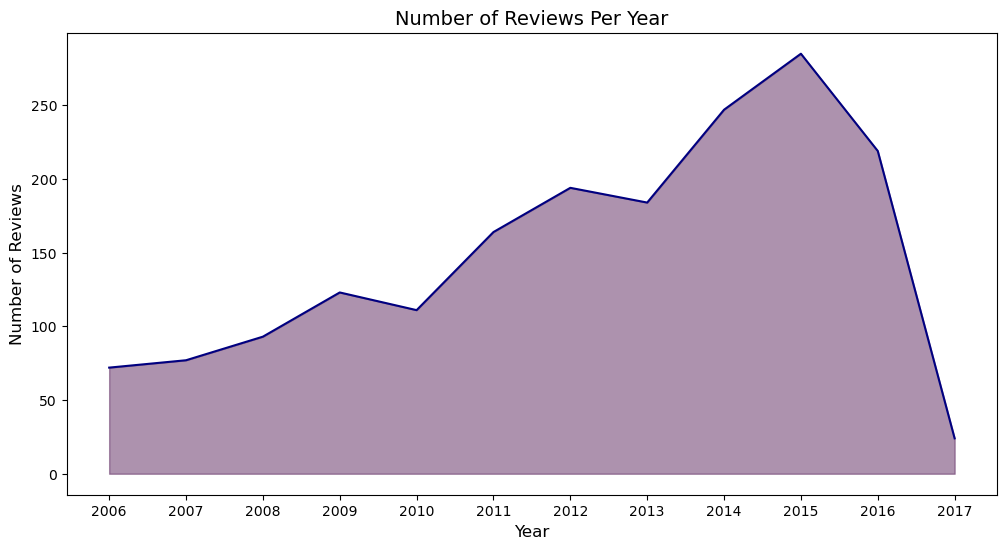

In [14]:
#bar chart to show how many reveiws per year
plt.figure(figsize=(12, 6))
plt.fill_between(sorted_reviews['review_date'], sorted_reviews['count'], color="#5C265F", alpha=0.5)  # Fill the area under the line
plt.plot(sorted_reviews['review_date'], sorted_reviews['count'], color='navy')
plt.title('Number of Reviews Per Year', fontsize=14)
plt.xticks(sorted_reviews['review_date'])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

In [15]:
#review count by company
company_review = chocolate.groupby(['review_date', 'company_maker'])['review_date'].value_counts()
print(company_review)

review_date  company_maker         
2006         Amedei                    2
             Bonnat                    7
             Cote d' Or (Kraft)        1
             Dolfin (Belcolade)        1
             Domori                    3
                                      ..
2017         Madre                     1
             Smooth Chocolator, The    1
             Soul                      6
             Spencer                   3
             Xocolla                   2
Name: count, Length: 728, dtype: int64


In [16]:
company_review = chocolate.groupby(['company_maker', 'review_date'])['review_date'].value_counts().reset_index()
company_reviews = company_review
company_reviews.head()

,company_maker,review_date,count
0,A. Morin,2012,2
1,A. Morin,2013,11
2,A. Morin,2014,5
3,A. Morin,2015,4
4,A. Morin,2016,1


In [17]:
# Sort Cocoa Percentage for US only
us_chocolate = chocolate[chocolate['company_location'].isin(['U.S.A.'])]


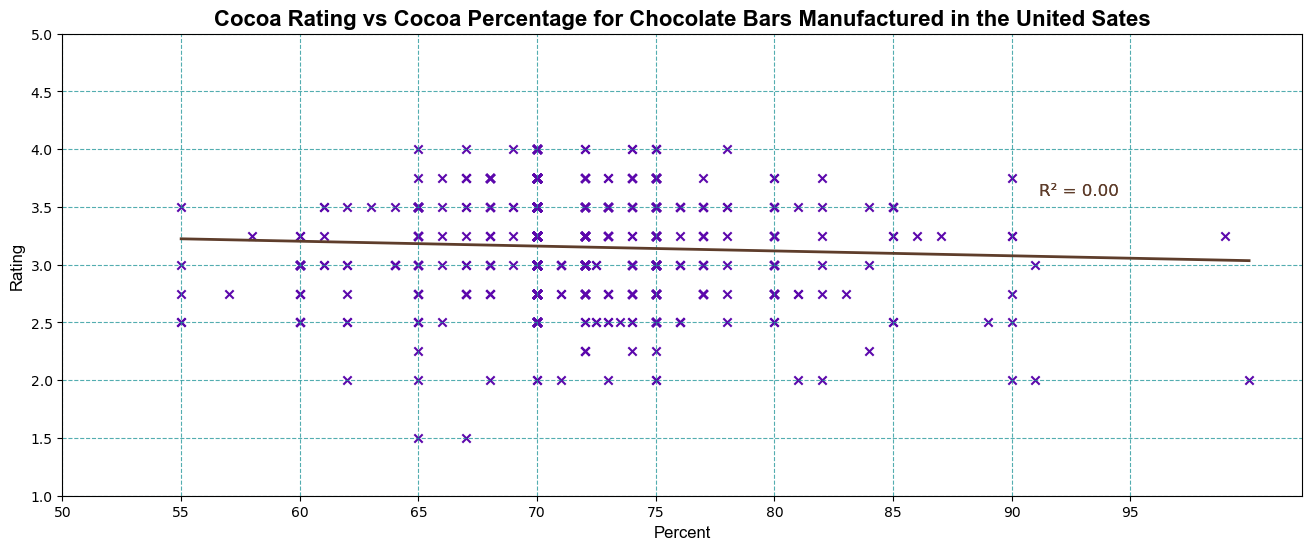

In [26]:


# make a scatter plot
# Change Canvas Size
plt.figure(figsize=(16, 6))
# Create a basic plot
plt.scatter(us_chocolate.cocoa_percent, us_chocolate.rating, color="#5C08AC", marker="x")

#regression line
slope, intercept, rvalue, pvalue, stderr = linregress(us_chocolate.cocoa_percent, us_chocolate.rating)
regression_line = slope * us_chocolate.cocoa_percent + intercept
plt.plot(us_chocolate.cocoa_percent, regression_line, color="#5E3D2B", linewidth=2, label='Regression Line')
r_squared = rvalue**2
plt.text(0.82, 0.65, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, color="#5E3D2B", ha='center')

# Customizations
ticks = np.arange(50, 100, 5)
plt.xticks(ticks)
# Change colors
# Add in reference lines
# Add Labels/Title
plt.ylim(1,5)
plt.xlabel("Percent", fontfamily="Arial", fontsize=12)
plt.ylabel("Rating", fontfamily="Arial", fontsize=12)
plt.title("Cocoa Rating vs Cocoa Percentage for Chocolate Bars Manufactured in the United Sates", fontweight="bold", fontsize=16, fontfamily="Arial")
# Add in a background grid
plt.grid(linestyle="--", color="#199296", alpha=0.75)
plt.text(0.82, 0.65, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, color="#5E3D2B", ha='center')
# Show plot
plt.show()

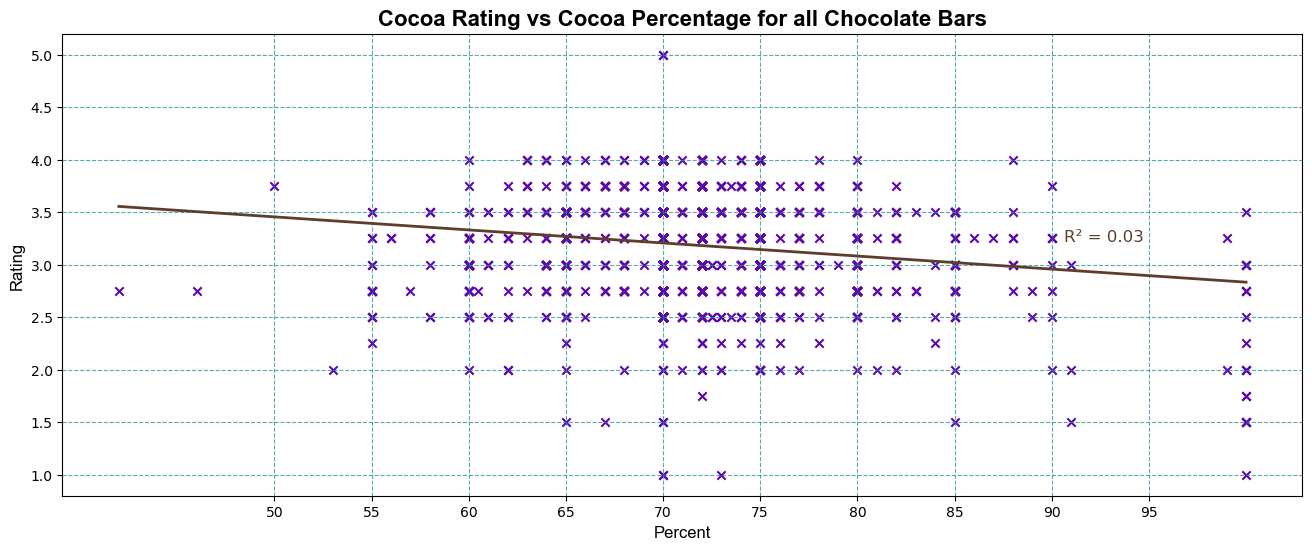

In [31]:

chocolate = chocolate.sort_values(by='cocoa_percent', ascending=True)
# make a scatter plot
# Change Canvas Size
plt.figure(figsize=(16, 6))
# Create a basic plot
plt.scatter(chocolate.cocoa_percent, chocolate.rating, color="#5C08AC", marker="x")

#regression line
slope, intercept, rvalue, pvalue, stderr = linregress(chocolate.cocoa_percent, chocolate.rating)
regression_line = slope * chocolate.cocoa_percent + intercept
plt.plot(chocolate.cocoa_percent, regression_line, color="#5E3D2B", linewidth=2, label='Regression Line')
r_squared = rvalue**2
plt.text(0.84, 0.55, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, color="#5E3D2B", ha='center')

# Customizations
ticks = np.arange(50, 100, 5)
plt.xticks(ticks)
# Change colors
# Add in reference lines
# Add Labels/Title
plt.xlabel("Percent", fontfamily="Arial", fontsize=12)
plt.ylabel("Rating", fontfamily="Arial", fontsize=12)
plt.title("Cocoa Rating vs Cocoa Percentage for all Chocolate Bars", fontweight="bold", fontsize=16, fontfamily="Arial")
# Add in a background grid
plt.grid(linestyle="--", color="#199296", alpha=0.75)
# Show plot
plt.show()
